## Load the Data

In [1]:
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from fastai.dataset import ModelData

def get_data(bs, num_workers):
    PATH = "data/cifar10/"
    trn_dir, val_dir = PATH + 'train', PATH + 'test'
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    
    # Data transforms (normalization & data augmentation)
    tfms = [tt.ToTensor(), tt.Normalize(*stats)]
    aug_tfms = tt.Compose([tt.RandomCrop(32, padding=4), 
                           tt.RandomHorizontalFlip()] + tfms)
    # PyTorch datasets
    trn_ds = ImageFolder(trn_dir, aug_tfms)
    val_ds = ImageFolder(val_dir, tt.Compose(tfms))
    aug_ds = ImageFolder(val_dir, aug_tfms)
    
    # PyTorch data loaders
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, 
                        num_workers=num_workers, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, 
                        num_workers=num_workers, pin_memory=True)
    aug_dl = DataLoader(aug_ds, batch_size=bs, shuffle=False, 
                        num_workers=num_workers, pin_memory=True)
    
    # FastAI model data 
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz = 32
    
    return data

AttributeError: module 'torch' has no attribute 'float32'

In [2]:
def get_learner(arch, bs):
    """Create a FastAI learner using the given model"""
    data = get_data(bs, num_cpus())
    learn = ConvLearner.from_model_data(arch.cuda(), data)
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

def get_TTA_accuracy(learn):
    """Calculate accuracy with Test Time Agumentation(TTA)"""
    preds, targs = learn.TTA()
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

## Create the network

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def conv_2d(ni, nf, stride=1, ks=3):
    """3x3 convolution with 1 pixel padding"""
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    """BatchNorm → ReLU → Conv2D"""
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class BasicBlock(nn.Module):
    """Residual block with shortcut connection"""
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [7]:
def make_group(N, ni, nf, stride):
    """Group of residual blocks"""
    start = BasicBlock(ni, nf, stride)
    rest = [BasicBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

## Training & Evaluation

In [8]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.307771   1.355958   0.5027    
    1      0.973831   1.268146   0.5804                      
    2      0.815618   0.937404   0.6821                      
    3      0.726471   0.901928   0.7004                      
    4      0.654479   0.777541   0.7319                      
    5      0.630079   0.783178   0.7379                      
    6      0.614516   0.817597   0.7293                      
    7      0.606512   0.749424   0.7461                      
    8      0.587174   1.035898   0.6526                      
    9      0.575562   1.696366   0.5554                      
    10     0.566359   0.798111   0.7341                      
    11     0.545117   0.70227    0.7569                      
    12     0.499315   0.611959   0.7922                      
    13     0.469588   0.717421   0.767                       
    14     0.437617   0.695363   0.7639                      
    15     0.401804   0.489

In [9]:
get_TTA_accuracy(learn)

0.9287

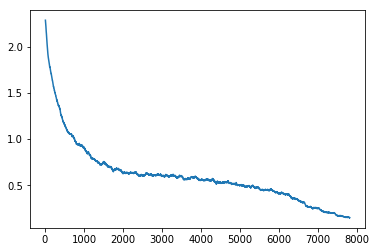

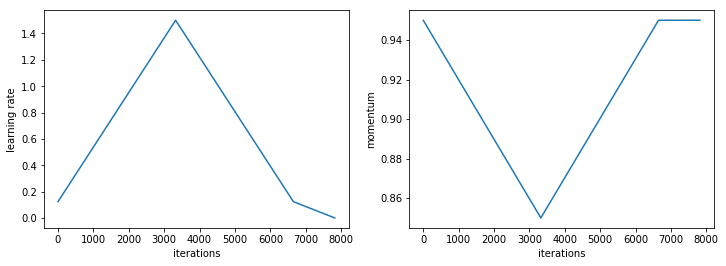

In [10]:
learn.sched.plot_loss()
learn.sched.plot_lr()